# Solution 1 IMPROVED: CNN with Stratified Split

**Key Improvements**:
- ⭐ **Stratified train/val split** by label to prevent distribution mismatch
- ⭐ **Larger stride (150)** to reduce temporal leakage (50% overlap vs 83%)
- ⭐ **User-level awareness** in splitting to prevent person-specific overfitting
- Strong regularization (dropout=0.4, weight_decay=1e-3)
- Early stopping on validation loss

In [14]:
# Set seed for reproducibility
SEED = 42

import os
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import random
import numpy as np
np.random.seed(SEED)
random.seed(SEED)

import torch
torch.manual_seed(SEED)
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
else:
    device = torch.device("cpu")

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

PyTorch version: 2.8.0+cu126
Device: cuda


In [15]:
# Load and preprocess data
df = pd.read_csv("pirate_pain_train.csv")
target = pd.read_csv("pirate_pain_train_labels.csv")

# Encode categorical features
number_cols = ['n_legs', 'n_hands', 'n_eyes']
for col in number_cols:
    df[col] = df[col].astype('category').cat.codes

# Normalize joint columns
joint_cols = ["joint_" + str(i).zfill(2) for i in range(31)]
for col in joint_cols:
    df[col] = df[col].astype(np.float32)

minmax_scaler = MinMaxScaler()
df[joint_cols] = minmax_scaler.fit_transform(df[joint_cols])

data_cols = number_cols + joint_cols

# Map labels
label_mapping = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
target['label'] = target['label'].map(label_mapping)

print("Data loaded and preprocessed")
print(f"Features: {len(data_cols)}")
print(f"Samples: {len(df['sample_index'].unique())}")
print(f"\nClass distribution:")
print(target['label'].value_counts().sort_index())

Data loaded and preprocessed
Features: 34
Samples: 661

Class distribution:
label
0    511
1     94
2     56
Name: count, dtype: int64


In [16]:
# ⭐ IMPROVED: Stratified split at USER level
# Create user-label mapping (one label per user)
user_labels = target.groupby('sample_index')['label'].first()

print("\nUser-level class distribution:")
print(user_labels.value_counts().sort_index())

# Stratified split to ensure both train and val have similar class distributions
train_users, val_users = train_test_split(
    user_labels.index,
    test_size=0.2,
    random_state=SEED,
    stratify=user_labels.values  # ← KEY IMPROVEMENT
)

print(f"\nTrain users: {len(train_users)}")
print(f"Val users: {len(val_users)}")
print("\nTrain user class distribution:")
print(user_labels[train_users].value_counts().sort_index())
print("\nVal user class distribution:")
print(user_labels[val_users].value_counts().sort_index())


User-level class distribution:
label
0    511
1     94
2     56
Name: count, dtype: int64

Train users: 528
Val users: 133

Train user class distribution:
label
0    408
1     75
2     45
Name: count, dtype: int64

Val user class distribution:
label
0    103
1     19
2     11
Name: count, dtype: int64


In [17]:
# Build sequences with LARGER STRIDE to reduce temporal leakage
WINDOW_SIZE = 600
STRIDE = 200  # ⭐ IMPROVED: 50% overlap instead of 83%

def build_sequences(df, target_df, window=300, stride=150):
    dataset = []
    labels = []

    for id in df['sample_index'].unique():
        temp = df[df['sample_index'] == id][data_cols].values
        label = target_df[target_df['sample_index'] == id]['label'].values[0]

        padding_len = window - len(temp) % window
        padding = np.zeros((padding_len, len(data_cols)), dtype='float32')
        temp = np.concatenate((temp, padding))

        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    return np.array(dataset), np.array(labels)

df_train = df[df['sample_index'].isin(train_users)]
df_val = df[df['sample_index'].isin(val_users)]

print(df.shape)

X_train, y_train = build_sequences(df_train, target, WINDOW_SIZE, STRIDE)
X_val, y_val = build_sequences(df_val, target, WINDOW_SIZE, STRIDE)

print(f"\nTraining sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")

train_counts = np.bincount(y_train.astype(int))
val_counts = np.bincount(y_val.astype(int))

print(f"\nTrain sequence distribution:")
for cls, count in enumerate(train_counts):
    print(f"  Class {cls}: {count} ({count/len(y_train)*100:.1f}%)")

print(f"\nVal sequence distribution:")
for cls, count in enumerate(val_counts):
    print(f"  Class {cls}: {count} ({count/len(y_val)*100:.1f}%)")

(105760, 40)

Training sequences: (528, 600, 34)
Validation sequences: (133, 600, 34)

Train sequence distribution:
  Class 0: 408 (77.3%)
  Class 1: 75 (14.2%)
  Class 2: 45 (8.5%)

Val sequence distribution:
  Class 0: 103 (77.4%)
  Class 1: 19 (14.3%)
  Class 2: 11 (8.3%)


In [18]:
# Direct oversampling to balance dataset
target_count = train_counts[0]
duplication_factors = np.ceil(target_count / train_counts).astype(int)

X_train_balanced = []
y_train_balanced = []

for cls in range(len(train_counts)):
    cls_indices = np.where(y_train == cls)[0]
    for _ in range(duplication_factors[cls]):
        X_train_balanced.append(X_train[cls_indices])
        y_train_balanced.append(y_train[cls_indices])

X_train_balanced = np.concatenate(X_train_balanced, axis=0)
y_train_balanced = np.concatenate(y_train_balanced, axis=0)

# Shuffle balanced dataset
shuffle_idx = np.random.permutation(len(X_train_balanced))
X_train_balanced = X_train_balanced[shuffle_idx]
y_train_balanced = y_train_balanced[shuffle_idx]

balanced_counts = np.bincount(y_train_balanced.astype(int))
print("Balanced distribution:", balanced_counts)
print(f"Total training samples: {len(y_train_balanced)}")

Balanced distribution: [408 450 450]
Total training samples: 1308


In [35]:
import torch
import torch.nn as nn
from typing import List

class _TemporalBlock(nn.Module):
    """
    Residual block: Conv1d (dilated, causal) -> Norm -> PReLU -> Dropout -> Conv1d -> Norm -> PReLU
    con skip connection + proiezione 1x1 se cambia il numero di canali.
    """
    def __init__(self, in_ch, out_ch, kernel_size, dilation, dropout=0.2, use_bn=True, causal=True):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        # causal padding: pad left-only; gestito in forward con F.pad
        self.causal = causal
        self.dilation = dilation
        self.kernel_size = kernel_size

        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, padding=0, dilation=dilation, bias=not use_bn)
        self.norm1 = nn.BatchNorm1d(out_ch) if use_bn else nn.Identity()
        self.act1  = nn.PReLU(out_ch)
        self.drop1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, padding=0, dilation=dilation, bias=not use_bn)
        self.norm2 = nn.BatchNorm1d(out_ch) if use_bn else nn.Identity()
        self.act2  = nn.PReLU(out_ch)
        self.drop2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(in_ch, out_ch, kernel_size=1) if in_ch != out_ch else nn.Identity()

    def _causal_pad(self, x):
        # Pad only on the left to preserve causality
        pad = (self.kernel_size - 1) * self.dilation
        if pad > 0:
            return nn.functional.pad(x, (pad, 0))
        return x

    def forward(self, x):
        # x: (B, C, T)
        y = self._causal_pad(x) if self.causal else x
        y = self.conv1(y)
        y = self.norm1(y)
        y = self.act1(y)
        y = self.drop1(y)

        y = self._causal_pad(y) if self.causal else y
        y = self.conv2(y)
        y = self.norm2(y)
        y = self.act2(y)
        y = self.drop2(y)

        s = self.downsample(x)
        return y + s  # residual


class YourModel(nn.Module):
    """
    TCNClassifier:
    - Input:  (batch, seq_len, input_size)
    - Output: (batch, num_classes) logits
    Kwargs:
        channels: List[int] — ampiezza dei layer (es. [64,128,256])
        kernel_size: int — dimensione kernel (es. 5)
        dropout: float — dropout nei blocchi (es. 0.3)
        use_bn: bool — usare BatchNorm nei blocchi
        causal: bool — conv causali (True) o 'same' simmetrica (False)
        gap: str — 'avg' (default) o 'max' per il pooling temporale
    """
    def __init__(self, input_size, num_classes, **kwargs):
        super().__init__()
        channels: List[int] = kwargs.get('channels', [64, 128, 256])
        kernel_size: int     = kwargs.get('kernel_size', 5)
        dropout: float       = kwargs.get('dropout', 0.3)
        use_bn: bool         = kwargs.get('use_bn', True)
        causal: bool         = kwargs.get('causal', True)
        gap: str             = kwargs.get('gap', 'avg')

        assert kernel_size >= 2 and kernel_size % 1 == 0, "kernel_size deve essere >=2"
        assert gap in ('avg', 'max'), "gap deve essere 'avg' o 'max'"

        layers = []
        in_ch = input_size  # trattiamo le feature come canali
        # dilations: 1,2,4,8,... per ogni blocco
        for i, out_ch in enumerate(channels):
            dilation = 2 ** i
            layers.append(
                _TemporalBlock(
                    in_ch=in_ch,
                    out_ch=out_ch,
                    kernel_size=kernel_size,
                    dilation=dilation,
                    dropout=dropout,
                    use_bn=use_bn,
                    causal=causal
                )
            )
            in_ch = out_ch

        self.tcn = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool1d(1) if gap == 'avg' else nn.AdaptiveMaxPool1d(1)
        self.head = nn.Sequential(
            nn.Flatten(),                  # (B, C, 1) -> (B, C)
            nn.LayerNorm(channels[-1]),
            nn.Dropout(dropout),
            nn.Linear(channels[-1], num_classes)
        )

    def forward(self, x):
        # x: (B, T, F) -> permuta a (B, F, T) per Conv1d
        x = x.transpose(1, 2)
        y = self.tcn(x)             # (B, C, T)
        y = self.pool(y)            # (B, C, 1)
        logits = self.head(y)       # (B, num_classes)
        return logits

    # Esempio Pirate Pain (finestre 200, 30 feature per timestep)
model = YourModel(
    input_size=34,
    num_classes=3,
    channels=[64,128,256],
    kernel_size=5,
    dropout=0.4,
    causal=True,
    use_bn=True,
    gap='avg'
).to(device) # Moved model to device

In [36]:
# Create dataloaders
BATCH_SIZE = 16

train_ds = TensorDataset(torch.from_numpy(X_train_balanced).float(), torch.from_numpy(y_train_balanced).long())
val_ds = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 82
Val batches: 9


In [37]:
# Training setup with STRONGER regularization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-3  # ⭐ IMPROVED: 1e-3 instead of 1e-4
)
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

def train_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Check for NaN/inf loss *before* backward pass
        if not torch.isfinite(loss):
            print(f"Warning: Non-finite loss encountered (NaN/Inf). Skipping backward pass and optimizer step for this batch.")
            continue

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * inputs.size(0)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return avg_loss, f1

def val_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return avg_loss, f1, all_preds, all_labels

print("Training functions ready")

Training functions ready


In [38]:
# Train with early stopping
print("=" * 80)
print("Training IMPROVED CNN Model with Stratified Split")
print("=" * 80)

EPOCHS = 1000
best_val_f1 = 0.0 # Changed to track best F1
best_val_loss_at_best_f1 = float('inf') # Store loss corresponding to best F1
patience = 100
patience_counter = 0
best_epoch = 0 # To log which epoch had the best F1

# Initialize training_history dictionary
training_history = {
    'train_loss': [],
    'val_loss': [],
    'train_f1': [],
    'val_f1': []
}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_f1 = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
    val_loss, val_f1, val_preds, val_labels = val_epoch(model, val_loader, criterion, device)

    # Append current epoch's metrics to history
    training_history['train_loss'].append(train_loss)
    training_history['val_loss'].append(val_loss)
    training_history['train_f1'].append(train_f1)
    training_history['val_f1'].append(val_f1)

    # Check if val_loss is NaN
    is_val_loss_nan = torch.isnan(torch.tensor(val_loss))

    if not is_val_loss_nan and val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_val_loss_at_best_f1 = val_loss
        patience_counter = 0
        best_epoch = epoch
        torch.save(model.state_dict(), 'cnn_improved_best.pt')
        print(f"Epoch {epoch:3d}/{EPOCHS} | Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | Val: Loss={val_loss:.4f}, F1={val_f1:.4f} ⭐ BEST F1")
    else:
        patience_counter += 1
        if epoch % 5 == 0 or epoch == 1:
            val_loss_str = f"{val_loss:.4f}" if not is_val_loss_nan else "NaN"
            print(f"Epoch {epoch:3d}/{EPOCHS} | Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | Val: Loss={val_loss_str}, F1={val_f1:.4f}")

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch} (no improvement in F1 or NaN loss for {patience} epochs)")
        break

print("\n" + "=" * 80)
print(f"Best validation F1: {best_val_f1:.4f} (from epoch {best_epoch}, loss={best_val_loss_at_best_f1:.4f})")
print("=" * 80)


Training IMPROVED CNN Model with Stratified Split
Epoch   1/1000 | Train: Loss=0.9202, F1=0.5677 | Val: Loss=0.5854, F1=0.7772 ⭐ BEST F1
Epoch   2/1000 | Train: Loss=0.6458, F1=0.7191 | Val: Loss=0.7239, F1=0.7939 ⭐ BEST F1
Epoch   3/1000 | Train: Loss=0.5967, F1=0.7622 | Val: Loss=0.6884, F1=0.8304 ⭐ BEST F1
Epoch   4/1000 | Train: Loss=0.5140, F1=0.7829 | Val: Loss=0.6575, F1=0.8446 ⭐ BEST F1
Epoch   5/1000 | Train: Loss=0.4848, F1=0.8026 | Val: Loss=0.5676, F1=0.8293
Epoch   6/1000 | Train: Loss=0.4361, F1=0.8272 | Val: Loss=0.4703, F1=0.8651 ⭐ BEST F1
Epoch   9/1000 | Train: Loss=0.3849, F1=0.8516 | Val: Loss=0.3934, F1=0.8735 ⭐ BEST F1
Epoch  10/1000 | Train: Loss=0.3243, F1=0.8645 | Val: Loss=0.4816, F1=0.8624
Epoch  11/1000 | Train: Loss=0.2994, F1=0.8823 | Val: Loss=0.4393, F1=0.8824 ⭐ BEST F1
Epoch  13/1000 | Train: Loss=0.2959, F1=0.8846 | Val: Loss=0.4829, F1=0.8934 ⭐ BEST F1
Epoch  15/1000 | Train: Loss=0.2789, F1=0.9006 | Val: Loss=0.4454, F1=0.8986 ⭐ BEST F1
Epoch  18/100

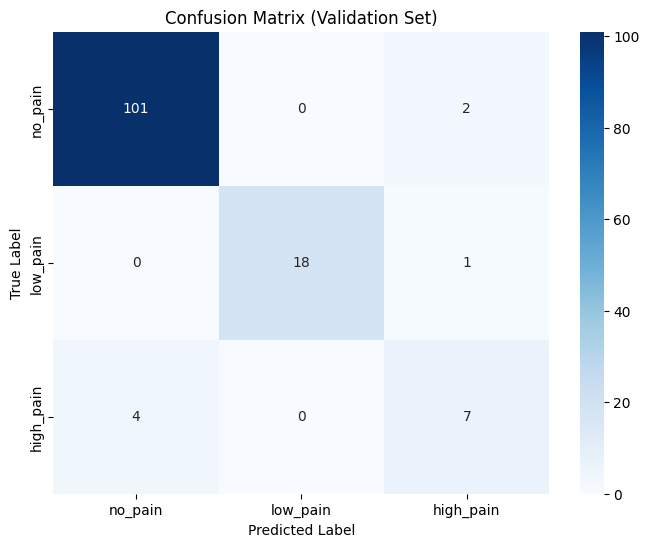

In [39]:
# @title Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions for the validation set
model.eval()
val_predictions = []
val_targets = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions.extend(predicted.cpu().numpy())
        val_targets.extend(targets.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(val_targets, val_predictions)

# Define class labels
class_labels = ['no_pain', 'low_pain', 'high_pain']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

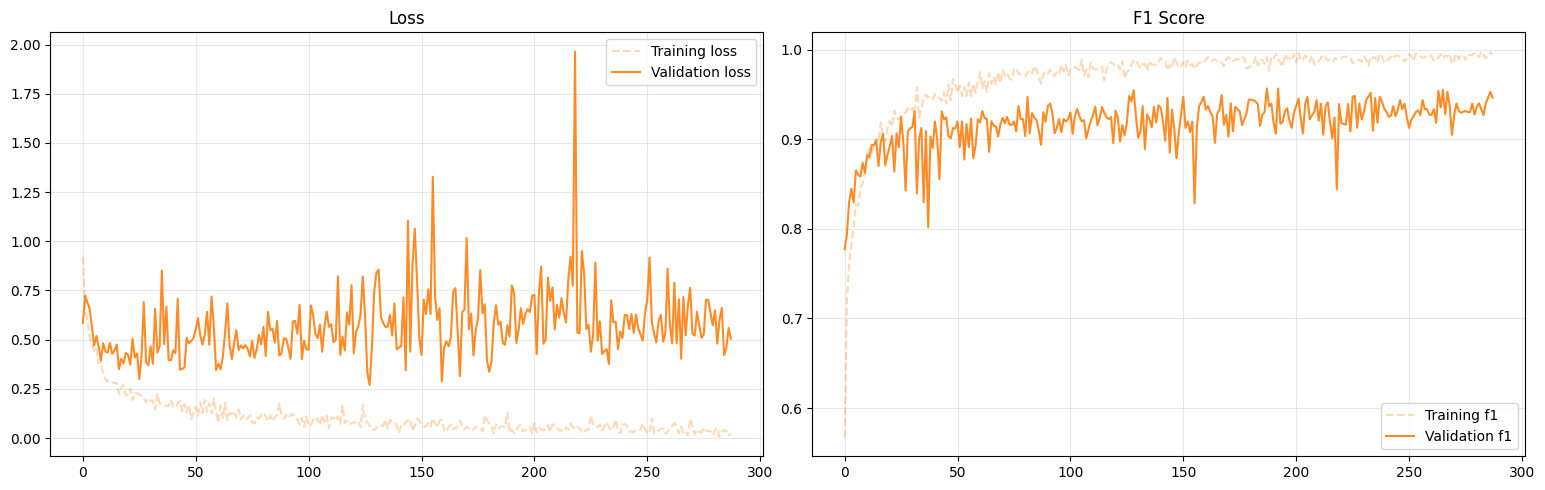

In [40]:
# @title Plot History

# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

In [41]:
# Final evaluation
model.load_state_dict(torch.load('cnn_improved_best.pt'))
_, val_f1, val_preds, val_labels = val_epoch(model, val_loader, criterion, device)

print("\n" + "=" * 80)
print("📊 FINAL RESULTS (IMPROVED CNN with Stratified Split)")
print("=" * 80)
print(f"Validation F1: {val_f1:.4f}")

print("\n📋 Per-class metrics:")
print(classification_report(val_labels, val_preds, target_names=['no_pain', 'low_pain', 'high_pain'], digits=4))

print("\n📈 Confusion Matrix:")
cm = confusion_matrix(val_labels, val_preds)
print(cm)

unique_preds, counts = np.unique(val_preds, return_counts=True)
print("\n🎯 Prediction distribution:")
for cls, count in zip(unique_preds, counts):
    print(f"  Class {cls}: {count} predictions ({count/len(val_preds)*100:.1f}%)")

if len(unique_preds) >= 3:
    print("\n✅ SUCCESS: Model predicts ALL 3 classes!")
    print("\n💡 Key improvements:")
    print("   - Stratified split ensures fair validation")
    print("   - Larger stride reduces temporal leakage")
    print("   - Stronger regularization prevents overfitting")
elif len(unique_preds) == 2:
    print("\n⚠️  PARTIAL: Predicts 2 out of 3 classes")
else:
    print("\n❌ FAILED: Stuck on 1 class")


📊 FINAL RESULTS (IMPROVED CNN with Stratified Split)
Validation F1: 0.9566

📋 Per-class metrics:
              precision    recall  f1-score   support

     no_pain     0.9804    0.9709    0.9756       103
    low_pain     1.0000    0.9474    0.9730        19
   high_pain     0.6923    0.8182    0.7500        11

    accuracy                         0.9549       133
   macro avg     0.8909    0.9121    0.8995       133
weighted avg     0.9594    0.9549    0.9566       133


📈 Confusion Matrix:
[[100   0   3]
 [  0  18   1]
 [  2   0   9]]

🎯 Prediction distribution:
  Class 0: 102 predictions (76.7%)
  Class 1: 18 predictions (13.5%)
  Class 2: 13 predictions (9.8%)

✅ SUCCESS: Model predicts ALL 3 classes!

💡 Key improvements:
   - Stratified split ensures fair validation
   - Larger stride reduces temporal leakage
   - Stronger regularization prevents overfitting
